Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Using the AWS Batch Architecture for Protein Folding

This notebook allows you to predict multiple protein sequences from the CAMEO data set between 2022-04-08 and 2022-07-02

## Table of Contents
0. [Install Dependencies](#0.-Install-Dependencies)
1. [Run a monomer analysis job](#1.-Run-a-monomer-analysis-job)
2. [Run a multimer analysis job](#2.-Run-a-multimer-analysis-job) 
3. [Analyze multiple proteins](#3.-Analyze-multiple-proteins)

## 0. Install Dependencies

In [2]:
# Import required Python packages

import boto3
from datetime import datetime
from batchfold.batchfold_environment import BatchFoldEnvironment
from batchfold.jackhmmer_job import JackhmmerJob
from batchfold.openfold_job import OpenFoldJob
from batchfold.alphafold2_job import AlphaFold2Job
from batchfold.batchfold_target import BatchFoldTarget
from batchfold.mmseqs2_job import MMseqs2Job
import matplotlib.pyplot as plt
from nbhelpers import nbhelpers
import os

# Get client information
boto_session = boto3.session.Session(profile_name="bloyal+proteinfolding-Admin")
batch_environment = BatchFoldEnvironment(boto_session = boto_session)

S3_BUCKET = batch_environment.default_bucket
print(f" S3 bucket name is {S3_BUCKET}")

 S3 bucket name is batch-protein-folding-220721-co-batchfolds3bucket-seugrwuuet85


## 1. Get target list

In [3]:
pdb_list = ["7Q4L_A", "7DUV_A", "7PP2_A", "7OIO_A", "7T9X_A"]
nbhelpers.get_pdb_data(pdb_list)


structure ID is 7Q4L
chain ID is A
structure ID is 7DUV
chain ID is A
structure ID is 7PP2
chain ID is A
structure ID is 7OIO
chain ID is A
structure ID is 7T9X
chain ID is A


## 2. Run MSA generation and folding jobs

In [9]:
from pathlib import Path
data_dir = "data/fasta"

for file in [ file for file in os.listdir(data_dir) if Path(file).suffix in [".fa", ".fasta"] ]:
    print(os.path.join(data_dir, file))
    target_id = file.split(".")[0]
    target = BatchFoldTarget(target_id=target_id, s3_bucket=S3_BUCKET, boto_session=boto_session)
    target.add_fasta(os.path.join(data_dir, file))
    target.upload_fasta()

    jackhmmer_job_name = target.target_id + "_JackhmmerJob_" + datetime.now().strftime("%Y%m%d%s")
    jackhmmer_job = JackhmmerJob(
            job_name = jackhmmer_job_name,
            target_id = target.target_id,
            fasta_s3_uri = target.get_fasta_s3_uri(),
            output_s3_uri = target.get_msas_s3_uri(),
            boto_session = boto_session,
            cpu = 16,
            memory = 32
        )

    alphafold2_job_name = target.target_id + "_AlphaFold2Job_" + datetime.now().strftime("%Y%m%d%s")
    alphafold2_job = AlphaFold2Job(
        job_name = alphafold2_job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri()+"/jackhmmer",
        output_s3_uri = target.get_predictions_s3_uri() + "/" + alphafold2_job_name,
        max_template_date = "2022-01-01",
        use_precomputed_msas = True,
        model_preset = "monomer_ptm",    
        benchmark = True,
        cpu = 4,
        memory = 16,
        gpu = 1
    )

    # jackhmmer_submission = batch_environment.submit_job(jackhmmer_job, job_queue_name="GravitonSpotJobQueue")
    # alphafold2_submission = batch_environment.submit_job(alphafold2_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission])

    mmseqs2_job_name = target.target_id + "_MMseqs2Job_" + datetime.now().strftime("%Y%m%d%s")
    mmseqs2_job = MMseqs2Job(
            job_name = mmseqs2_job_name,
            target_id = target.target_id,
            fasta_s3_uri = target.get_fasta_s3_uri(),
            output_s3_uri = target.get_msas_s3_uri(),
            boto_session = boto_session,
            cpu = 64,
            memory = 500
        )

    openfold_job_name = target.target_id + "_OpenFoldJob_" + datetime.now().strftime("%Y%m%d%s")
    openfold_job = OpenFoldJob(
        job_name = openfold_job_name,
        boto_session = boto_session,
        target_id = target.target_id,
        fasta_s3_uri = target.get_fasta_s3_uri(),
        msa_s3_uri = target.get_msas_s3_uri()+"/jackhmmer/",
        output_s3_uri = target.get_predictions_s3_uri() + "/" + openfold_job_name,
        max_template_date = "2022-01-01",
        use_precomputed_msas = True,
        config_preset = "finetuning_ptm",
        openfold_checkpoint_path = "openfold_params/finetuning_ptm_2.pt",
        save_outputs = True,
        cpu = 4,
        memory = 16,
        gpu = 1
    )

    mmseqs2_submission = batch_environment.submit_job(mmseqs2_job, job_queue_name="GravitonSpotJobQueue")
    openfold_submission = batch_environment.submit_job(openfold_job, job_queue_name="G4dnJobQueue", depends_on=[mmseqs2_submission])

data/fasta/7Q4L_A.fasta
data/fasta/7PP2_A.fasta
data/fasta/7DUV_A.fasta
data/fasta/7T9X_A.fasta
data/fasta/7OIO_A.fasta


Once the jobs are finished, download the results

## 3. Download Results

In [4]:
target = BatchFoldTarget(target_id="7OIO_A", s3_bucket=S3_BUCKET, boto_session=boto_session)
target.download_all(local_path="data")

1 files downloaded from s3.
7 files downloaded from s3.
0 files downloaded from s3.
23 files downloaded from s3.
3 files downloaded from s3.
0 files downloaded from s3.
0 files downloaded from s3.
0 files downloaded from s3.


'/Users/bloyal/batch-protein-folding/notebooks/data'

## 4. Visualize Results

### Alignment Data

399 Sequences Found in uniref90
1253 Sequences Found in bfd
319 Sequences Found in mgnify

1950 Sequences Found in Total



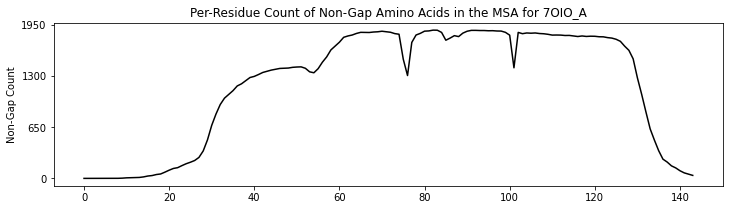

In [5]:
id = target.target_id
sto_path = f"data/{id}/msas/jackhmmer"
plt = nbhelpers.msa_plot(id, sto_path)
plt.show()

Structure Data

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

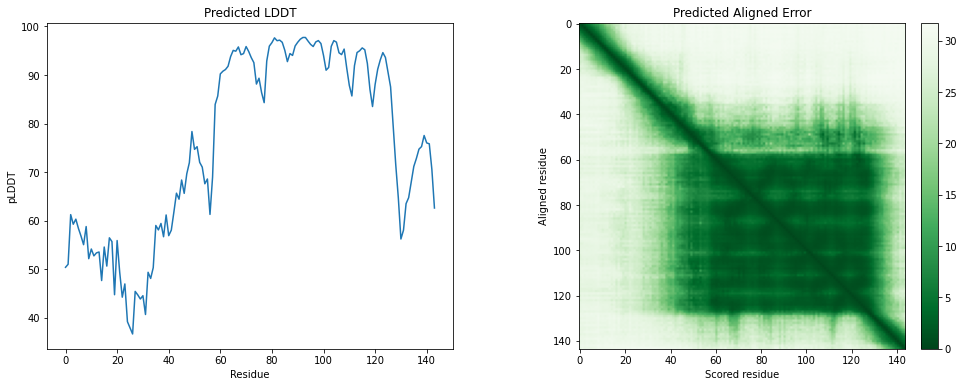

In [6]:
nbhelpers.pdb_plot(pdb_path = "data/7OIO_A/predictions/7OIO_A_OpenFoldJob_202207271658954578", show_sidechains=False).show()

## 5. Compare result to experimental structure